In [1]:
import meep as mp
import meep.adjoint as mpa
from meep import Animate2D
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle

mp.verbosity(0)
Si = mp.Medium(index=3.4)
SiO2 = mp.Medium(index=1.44)

/home/311514090/anaconda3/envs/mp/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/311514090/anaconda3/envs/mp/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/311514090/anaconda3/envs/mp/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/311514090/anaconda3/envs/mp/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
waveguide_width = 0.5
design_region_width = 2.5
design_region_height = 2.5

waveguide_length = 0.5

pml_size = 1.0

resolution = 20

frequencies = 1 / np.linspace(1.5, 1.6, 10)

In [3]:
minimum_length = 0.09  # minimum length scale (microns)
eta_i = (
    0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)
print(filter_radius)
design_region_resolution = int(1 * resolution)

0.20124611797498096


In [4]:
Sx = 2 * pml_size + 2 * waveguide_length + design_region_width
Sy = 2 * pml_size + design_region_height + 0.5
cell_size = mp.Vector3(Sx, Sy)

pml_layers = [mp.PML(pml_size)]

fcen = 1 / 1.55
width = 0.1
fwidth = width * fcen
source_center = [-Sx / 2 + pml_size + waveguide_length / 3, 0, 0]
source_size = mp.Vector3(0, Sy, 0)
kpoint = mp.Vector3(1, 0, 0)
src = mp.GaussianSource(frequency=fcen, fwidth=fwidth)
source = [
    mp.EigenModeSource(
        src,
        eig_band=1,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
        size=source_size,
        center=source_center,
    )
]

In [5]:
Nx = int(design_region_resolution * design_region_width) 
Ny = int(design_region_resolution * design_region_height) 

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), SiO2, Si, grid_type="U_MEAN")
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)

In [6]:
x_g = np.linspace(-design_region_width / 2, design_region_width / 2, Nx)
y_g = np.linspace(-design_region_height / 2, design_region_height / 2, Ny)
X_g, Y_g = np.meshgrid(x_g, y_g, sparse=True, indexing="ij")

left_wg_mask = (X_g == -design_region_width / 2) & (np.abs(Y_g) <= waveguide_width / 2)
top_wg_mask = (Y_g == design_region_width / 2) & (np.abs(X_g) <= waveguide_width / 2)
Si_mask = left_wg_mask | top_wg_mask

border_mask = (
    (X_g == -design_region_width / 2)
    | (X_g == design_region_width / 2)
    | (Y_g == -design_region_height / 2)
    | (Y_g == design_region_height / 2)
)
SiO2_mask = border_mask.copy()
SiO2_mask[Si_mask] = False

In [7]:
def mapping(x, eta, beta):
    x = npa.where(Si_mask.flatten(), 1, npa.where(SiO2_mask.flatten(), 0, x))

    # filter
    filtered_field = mpa.conic_filter(
        x,
        filter_radius,
        design_region_width,
        design_region_height,
        design_region_resolution,
    )

    # projection
    projected_field = mpa.tanh_projection(filtered_field, beta, eta)

    projected_field = (
        npa.rot90(projected_field.T, 2) + projected_field
    ) / 2  # 90-degree symmetry

    # interpolate to actual materials
    return projected_field.flatten()

In [8]:
geometry = [
    mp.Block(
        center=mp.Vector3(x=-Sx / 4), material=Si, size=mp.Vector3(Sx / 2, 0.5, 0)
    ),  # horizontal waveguide
    mp.Block(
        center=mp.Vector3(y=Sy / 4), material=Si, size=mp.Vector3(0.5, Sy / 2, 0)
    ),  # vertical waveguide
    mp.Block(
        center=design_region.center, size=design_region.size, material=design_variables
    ),  # design region
    # mp.Block(center=design_region.center, size=design_region.size, material=design_variables,
    #         e1=mp.Vector3(x=-1).rotate(mp.Vector3(z=1), np.pi/2), e2=mp.Vector3(y=1).rotate(mp.Vector3(z=1), np.pi/2))
    #
    # The commented lines above impose symmetry by overlapping design region with the same design variable. However,
    # currently there is an issue of doing that; instead, we use an alternative approach to impose symmetry.
    # See https://github.com/NanoComp/meep/issues/1984 and https://github.com/NanoComp/meep/issues/2093
]
sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=SiO2,
    resolution=resolution,
)

In [9]:
mode = 1

TE0 = mpa.EigenmodeCoefficient(
    sim,
    mp.Volume(
        center=mp.Vector3(x=-Sx / 2 + pml_size + 2 * waveguide_length / 3),
        size=mp.Vector3(y=Sy),
    ),
    mode,
)
TE_top = mpa.EigenmodeCoefficient(
    sim,
    mp.Volume(
        center=mp.Vector3(0, Sx / 2 - pml_size - 2 * waveguide_length / 3, 0),
        size=mp.Vector3(x=Sx),
    ),
    mode,
)
ob_list = [TE0, TE_top]


def J(source, top):
    power = npa.abs(top / source) ** 2
    return npa.mean(power)

In [10]:
opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J,
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=frequencies
)

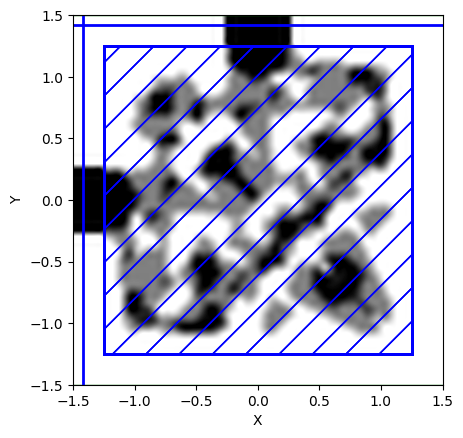

In [11]:
%matplotlib inline
plt.figure()
rho_vector = np.random.rand(Nx * Ny)
opt.update_design([mapping(rho_vector, eta_i, 1e3)])
opt.plot2D(True, output_plane=mp.Volume(center=(0, 0, 0), size=(3, 3, 0)))

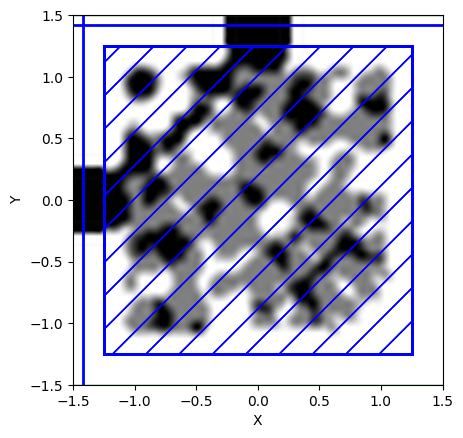

In [12]:
%matplotlib inline
plt.figure()
rho_vector = np.random.rand(Nx * Ny)
opt.update_design([mapping(rho_vector, eta_i, 1e3)])
opt.plot2D(True, output_plane=mp.Volume(center=(0, 0, 0), size=(3, 3, 0)))

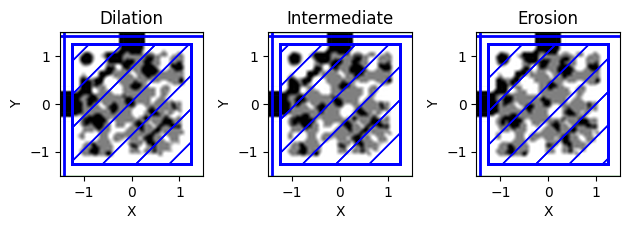

In [13]:
%matplotlib inline
beta = 2048

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
opt.update_design([mapping(rho_vector, 0.498, beta)])
opt.plot2D(True, ax=ax1, output_plane=mp.Volume(center=(0, 0, 0), size=(3, 3, 0)))
ax1.set_title("Dilation")

opt.update_design([mapping(rho_vector, 0.5, beta)])
opt.plot2D(True, ax=ax2, output_plane=mp.Volume(center=(0, 0, 0), size=(3, 3, 0)))
ax2.set_title("Intermediate")

opt.update_design([mapping(rho_vector, 0.502, beta)])
opt.plot2D(True, ax=ax3, output_plane=mp.Volume(center=(0, 0, 0), size=(3, 3, 0)))
ax3.set_title("Erosion")

fig.tight_layout()

In [14]:
evaluation_history = []
cur_iter = [0]


def f(v, gradient, cur_beta):
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0, dJ_du = opt([mapping(v, eta_i, cur_beta)])  # compute objective and gradient

    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, cur_beta, np.sum(dJ_du, axis=1)
        )  # backprop

    evaluation_history.append(np.real(f0))

    cur_iter[0] = cur_iter[0] + 1

    return np.real(f0)

In [ ]:
%matplotlib ipympl

# Create the animation
animate = Animate2D(
    fields=None,
    realtime=True,
    eps_parameters={'contour': False, 'alpha': 1, 'frequency': 1/1.55},
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
    update_epsilon=True,  # required for the geometry to update dynamically
    sim = 0,
    nb=True         # required if running in a Jupyter notebook
    
)
# This will trigger the animation at the end of each simulation
opt.step_funcs=[mp.at_end(animate)]

algorithm = nlopt.LD_MMA
n = Nx * Ny  # number of parameters

# Initial guess
x = np.ones((n,)) * 0.5
x[Si_mask.flatten()] = 1  # set the edges of waveguides to silicon
x[SiO2_mask.flatten()] = 0  # set the other edges to SiO2

# lower and upper bounds
lb = np.zeros((Nx * Ny,))
lb[Si_mask.flatten()] = 1
ub = np.ones((Nx * Ny,))
ub[SiO2_mask.flatten()] = 0

cur_beta = 4
beta_scale = 2
num_betas = 6
update_factor = 12
for iters in range(num_betas):
    solver = nlopt.opt(algorithm, n)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_max_objective(lambda a, g: f(a, g, cur_beta))
    solver.set_maxeval(update_factor)
    x[:] = solver.optimize(x)
    cur_beta = cur_beta * beta_scale

Current iteration: 1
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 2
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 3
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 5
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 6
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 7
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 9
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 10
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 11
Starting forward run...
Starting adjoint run...

In [ ]:
animate.to_jshtml(fps=5)

In [ ]:
%matplotlib inline
plt.figure()
plt.plot(10 * np.log10(evaluation_history), "o-")
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("Average Insertion Loss (dB)")

In [ ]:
%matplotlib inline
opt.update_design([mapping(x, eta_i, cur_beta)])
plt.figure()
ax = plt.gca()
opt.plot2D(
    False,
    ax=ax,
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
)
circ = Circle((2, 2), minimum_length / 2)
ax.add_patch(circ)
ax.axis("off")

In [ ]:
f0, dJ_du = opt([mapping(x, eta_i, cur_beta // 2)], need_gradient=False)
frequencies = opt.frequencies
source_coef, top_coef = opt.get_objective_arguments()

top_profile = np.abs(top_coef / source_coef) ** 2

In [ ]:
%matplotlib inline
plt.figure()
plt.plot(1 / frequencies, top_profile * 100, "-o")
plt.grid(True)
plt.xlabel("Wavelength (microns)")
plt.ylabel("Transmission (%)")
# plt.ylim(98,100)
plt.show()

plt.figure()
plt.plot(1 / frequencies, 10 * np.log10(top_profile), "-o")
plt.grid(True)
plt.xlabel("Wavelength (microns)")
plt.ylabel("Insertion Loss (dB)")
# plt.ylim(-0.1,0)
plt.show()